# Modelo Matemática - Árvore de Steiner



    definição do modelo goes here.



## lendo dados

In [44]:
from classes import Network, MulticastGroup
from multicastpacking import MulticastPacking, solver
import reader

#instancen of the problem
file = "../../../MPP_instances/n120/b120_1.brite"

# listofopt = "..."

links = reader.get_network (file)
net = Network (links, nodes = 120)


mgroups = [MulticastGroup (g) for g in reader.get_groups (file) ]

problem = MulticastPacking (net, mgroups)

KSIZE = len(problem.groups)+1
NODES = net.nodes+1

## Definição de Variáveis

In [45]:
from gurobipy import *

m = Model ('Steiner Tree')

var_y = {} #variável que marca arestas usadas
var_x = {} #variável que controla o fluxo


k=2

for link in net.links:
    y=link[0],link[1]
    var_y[y]=m.addVar(vtype=GRB.BINARY, obj=1, name=str(y))
    y=link[1],link[0]
    var_y[y]=m.addVar(vtype=GRB.BINARY, obj=1, name=str(y))
    
m.update ()
    
for d in problem.groups[k-1].members:
    for link in net.links:
        y=link[0],link[1],d
        var_x[y]=m.addVar(vtype=GRB.BINARY, obj=1, name=str(y))
        y=link[1],link[0],d
        var_x[y]=m.addVar(vtype=GRB.BINARY, obj=1, name=str(y))
        
m.update ()

## Restrições de Fluxo

In [46]:
## fluxo 1

#fluxo saindo da fonte sk para o destino d no grupo K
for d in problem.groups[k-1].members:
    sk = problem.groups[k-1].source
    _name='flow1',d
    m.addConstr (
        quicksum ( var_x[x] for x in tuplelist (var_x).select ('*',sk,d) )
        -
        quicksum ( var_x[x] for x in tuplelist (var_x).select (sk,'*',d) )
        == -1,
        name=str(_name)
    )

m.update ()


#fluxo chegando no destino d no grupo K
for d in problem.groups[k-1].members:
    sk = problem.groups[k-1].source
    _name='flow2',d
    m.addConstr (
        quicksum (
            var_x[x] for x in tuplelist (var_x).select ('*',d,d)
        )
        -
        quicksum (
            var_x[x] for x in tuplelist (var_x).select (d,'*',d)
        )
        == 1,
        name=str(_name)
    )
        
m.update ()

# conservação de fluxo
for d in problem.groups[k-1].members:
    for j in xrange(1,NODES):
        sk = problem.groups[k-1].source
        _name='flow3',d,j   
        m.addConstr (
            quicksum(
                var_x[x] for x in tuplelist (var_x).select ('*',j,d) 
                if x[1] not in [sk, d]
            )
            -
            quicksum(
                var_x[x] for x in tuplelist (var_x).select (j,'*',d) 
                if x[0] not in [sk, d]
            )
            == 0,
            name=str(_name)
        )            

m.update ()

## Marcar aresta usada

In [47]:
for d in problem.groups[k-1].members:
    for link in net.links:
        x=link[0],link[1],d
        y=link[0],link[1]
        _name='mark',link[0],link[1],d
        m.addConstr ( var_x[x] <= var_y[y], 
            name=str(_name)
        )            
        x=link[1],link[0],d
        y=link[1],link[0]
        _name='mark',link[1],link[0],d
        m.addConstr ( var_x[x] <= var_y[y], 
            name=str(_name)
        )
        
m.update ()

## Função Objetivo - Custo

In [33]:
m.setObjective (
    quicksum (
        var_y[(y[0],y[1])] * net.links[y][0] for y in net.links.keys ()
    )
    +
    quicksum (
        var_y[(y[1],y[0])] * net.links[y][0] for y in net.links.keys ()
    )
)

## Função Objetivo = Número de Links

In [48]:
m.setObjective (
    quicksum (
        var_y[y] for y in tuplelist(var_y)
    )
)

In [49]:
m.optimize()

Optimize a model with 9632 rows, 8160 columns and 30720 nonzeros
Coefficient statistics:
  Matrix range    [1e+00, 1e+00]
  Objective range [1e+00, 1e+00]
  Bounds range    [1e+00, 1e+00]
  RHS range       [1e+00, 1e+00]
Found heuristic solution: objective 372
Presolve removed 92 rows and 62 columns
Presolve time: 0.06s
Presolved: 9540 rows, 8098 columns, 30520 nonzeros
Variable types: 0 continuous, 8098 integer (8098 binary)

Root relaxation: objective 2.500000e+01, 2204 iterations, 0.13 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      25.0000000   25.00000  0.00%     -    0s

Explored 0 nodes (2204 simplex iterations) in 0.21 seconds
Thread count was 2 (of 4 available processors)

Optimal solution found (tolerance 1.00e-04)
Best objective 2.500000000000e+01, best bound 2.500000000000e+01, gap 0.0%


## Código para Gerar dot da árvore

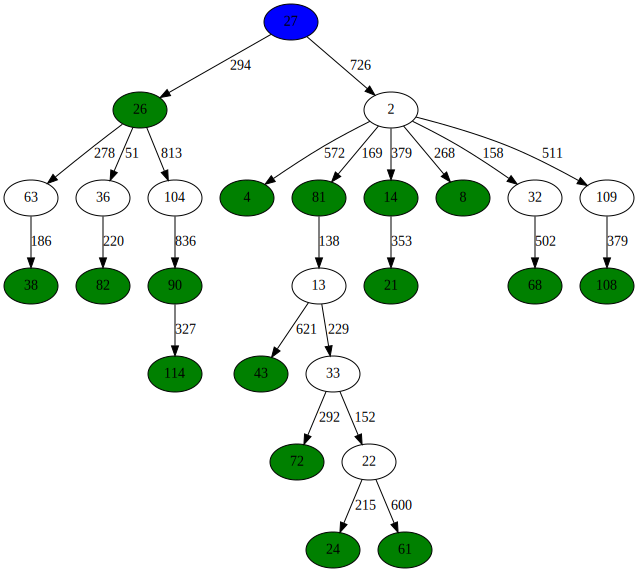

In [55]:
from graphviz import Digraph

g = Digraph ()

kid = k

#style of nodes (sk, Dk)
for d in problem.groups[kid-1].members:
    g.node (str (d), style='filled', fillcolor='green')

sk = problem.groups[kid-1].source
g.node (str(sk), style='filled', fillcolor='blue')

for y in var_y:
    if var_y[y].getAttr('X') == 1:
        if net.exists (y):
            g.edge ( str(y[0]) ,str(y[1]), str(net.properties(y)[0]))
        else:
            tmp = y[1],y[0],
            g.edge ( str(y[0]) ,str(y[1]), str(net.properties(tmp)[0]))
        

g